In [111]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.master(os.getenv('SPARK_MASTER_ADDRESS')).appName("Spark-application").getOrCreate()

24/04/30 17:43:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [112]:
sc = spark._jsc.sc()
n_workers = len([executor.host()for executor in sc.statusTracker().getExecutorInfos() ])-1 
print(n_workers)

2


In [113]:
!echo $SPARK_MASTER_ADDRESS
!echo $SPARK_MASTER_OOD_ADDRESS
!echo $SPARK_WORKER1_OOD_ADDRESS
!echo $SPARK_WORKER2_OOD_ADDRESS

spark://notch081.ipoib.int.chpc.utah.edu:7077
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8080
https://ondemand-class.chpc.utah.edu/rnode/notch081.ipoib.int.chpc.utah.edu/8081
https://ondemand-class.chpc.utah.edu/rnode/notch082.ipoib.int.chpc.utah.edu/8081


In [114]:
spark = SparkSession.builder \
    .master("spark://notch081.ipoib.int.chpc.utah.edu:7077") \
    .appName("MyAPP") \
    .getOrCreate()

24/04/30 17:43:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Stockwave to train LSTM model on 10 stocks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
file_list = [file for file in os.listdir('data') if file.endswith('.csv')]

In [4]:
file_list

['AAPL_data.csv',
 'CCL_data.csv',
 'CELG_data.csv',
 'CERN_data.csv',
 'CF_data.csv',
 'CHD_data.csv',
 'CHK_data.csv',
 'CHTR_data.csv',
 'CINF_data.csv',
 'CLX_data.csv',
 'CL_data.csv',
 'CMCSA_data.csv',
 'CMS_data.csv',
 'CNP_data.csv',
 'COF_data.csv',
 'COG_data.csv',
 'COO_data.csv',
 'COP_data.csv',
 'COST_data.csv',
 'COTY_data.csv',
 'CPB_data.csv',
 'CSX_data.csv',
 'CTSH_data.csv',
 'CTXS_data.csv',
 'CVS_data.csv',
 'CVX_data.csv',
 'DAL_data.csv',
 'DGX_data.csv',
 'DG_data.csv',
 'DHR_data.csv',
 'DISCA_data.csv',
 'DISCK_data.csv',
 'DISH_data.csv',
 'DIS_data.csv',
 'DLR_data.csv',
 'DPS_data.csv',
 'DRE_data.csv',
 'DRI_data.csv',
 'DTE_data.csv',
 'DUK_data.csv',
 'DVA_data.csv',
 'DVN_data.csv',
 'D_data.csv',
 'EA_data.csv',
 'EBAY_data.csv',
 'ED_data.csv',
 'EFX_data.csv',
 'EIX_data.csv',
 'EMR_data.csv',
 'EOG_data.csv',
 'EQR_data.csv',
 'EQT_data.csv',
 'ESRX_data.csv',
 'ESS_data.csv',
 'ES_data.csv',
 'ETN_data.csv',
 'ETR_data.csv',
 'EW_data.csv',
 'EXP

#### Feature Engineering to add "EMA" and "RSI" columns

In [118]:
from pyspark.sql.functions import col, lag, mean, when, avg, stddev
from pyspark.sql.window import Window

# Exponential Moving Average (EMA)
def add_ema(df, alpha=0.2):
    window_spec = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, Window.currentRow)
    df = df.withColumn("EMA", mean(col("close")).over(window_spec))
    return df

# Relative Strength Index (RSI)
def add_rsi(df, window=14):
    delta = col('close') - lag('close').over(Window.orderBy('date'))
    gain = when(delta > 0, delta).otherwise(0)
    loss = when(delta < 0, -delta).otherwise(0)
    avg_gain = mean(gain).over(Window.orderBy('date').rowsBetween(-window, Window.currentRow))
    avg_loss = mean(loss).over(Window.orderBy('date').rowsBetween(-window, Window.currentRow))
    rs = avg_gain / avg_loss
    df = df.withColumn('RSI', 100 - (100 / (1 + rs)))
    return df

#### Data Cleaning: Removing Null values and Outliers

In [119]:
dataframes_dict = {}
directory = 'data/'
for filename in file_list:
    # Load the CSV file into a DataFrame
    file_path = os.path.join(directory, filename)
    stock1 = spark.read.csv(file_path,header=True)

    # Type Casting
    from pyspark.sql.functions import to_date
    from pyspark.sql.types import *
    
    stock1 = stock1.withColumn("date", to_date(stock1["date"]).cast(DateType()))
    stock1 = stock1.withColumn("open", (stock1["open"]).cast(FloatType()))
    stock1 = stock1.withColumn("high", (stock1["high"]).cast(FloatType()))
    stock1 = stock1.withColumn("low", (stock1["low"]).cast(FloatType()))
    stock1 = stock1.withColumn("close", (stock1["close"]).cast(FloatType()))
    stock1 = stock1.withColumn("volume", (stock1["volume"]).cast(IntegerType()))

    # Feature Engineering
    stock1 = add_ema(stock1)
    stock1 = add_rsi(stock1)

    # Drop if there are any null values present
    stock1 = stock1.na.drop()

    # Remove outliers
    # Calculate mean and standard deviation
    for column in ["open", "close", "high", "low", "volume","EMA","RSI"]:
        mean_val = stock1.select(mean(col(column)).alias("mean")).collect()[0]["mean"]
        stddev_val = stock1.select(stddev(col(column)).alias("stddev")).collect()[0]["stddev"]
    
        # Set the threshold for outliers (3 standard deviations away from the mean)
        threshold = 3 * stddev_val
        
        # Filter out rows with values outside the threshold
        stock = stock1.filter((col(column) >= mean_val - threshold) & (col(column) <= mean_val + threshold))

    stock1 = stock1.na.drop()

    # Convert to pandas
    df = stock.toPandas()

    df = df.drop(columns= ['date', 'Name', 'volume'])
    
    # Extract the filename without '_data.csv'
    key = filename.replace('_data.csv', '')
    
    # Store the DataFrame in the dictionary
    dataframes_dict[key] = df

24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 17:43:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/04/30 1

In [120]:
dataframes_dict.keys()

dict_keys(['GIS', 'GLW', 'GPC', 'GPS', 'GRMN', 'GS', 'GT', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HCN', 'HES'])

In [121]:
dataframes_dict.values()

dict_values([           open       high        low      close        EMA        RSI
0     45.389999  45.445000  45.180000  45.330002  44.038889  95.348861
1     45.330002  45.669998  45.259998  45.669998  44.202000  95.820912
2     45.740002  46.010101  45.419998  45.419998  44.312727  89.166679
3     45.570000  46.029999  45.470001  46.009998  44.454166  90.692136
4     46.000000  46.369999  45.820000  46.279999  44.594615  91.255617
...         ...        ...        ...        ...        ...        ...
1246  58.900002  59.009998  57.715000  57.880001  55.626908  44.239633
1247  57.590000  57.599998  55.880001  55.950001  55.627166  36.455703
1248  55.830002  56.334999  54.009998  54.009998  55.625879  30.000004
1249  53.490002  55.853802  52.959999  55.779999  55.626002  37.720105
1250  55.470001  56.240002  54.619999  54.650002  55.625226  30.097963

[1251 rows x 6 columns],            open       high        low      close        EMA        RSI
0     12.970000  12.980000  12.730000 

#### Rearranging data to a window size of 5 for LSTM

In [122]:
def df_to_X_y2(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][3] #close value is y 
        y.append(label)
    return np.array(X), np.array(y)

X_y_dict = {}

for key, df in dataframes_dict.items():
    # Apply df_to_X_y2 function to the current DataFrame
    X, y = df_to_X_y2(df)
    # Store X, y pair in the new dictionary
    X_y_dict[key] = (X, y)

#### Splitting data into Train, Test and Validation

In [123]:
# Initialize empty dictionaries to store data splits
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}
y_train_dict = {}
y_val_dict = {}
y_test_dict = {}

# Loop through each entry in X_y_dict
for key, (X, y) in X_y_dict.items():
    # Calculate lengths of data splits
    data_len = len(X)
    training_data_len = int(np.ceil(data_len * 0.9))
    val_data_len = int(np.ceil(data_len * 0.05))
    test_data_len = data_len - training_data_len - val_data_len

    # Split the data
    X_train = X[:training_data_len]
    X_val = X[training_data_len:training_data_len + val_data_len]
    X_test = X[training_data_len + val_data_len:]
    
    y_train = y[:training_data_len]
    y_val = y[training_data_len:training_data_len + val_data_len]
    y_test = y[training_data_len + val_data_len:]
    
    # Store the splits in the dictionaries
    X_train_dict[key] = X_train
    X_val_dict[key] = X_val
    X_test_dict[key] = X_test
    y_train_dict[key] = y_train
    y_val_dict[key] = y_val
    y_test_dict[key] = y_test


#### Standardization (scaling the data)

In [124]:
def preprocess_X(X, means, stds):
    X[:, :, 0] = (X[:, :, 0] - means['open']) / stds['open']
    X[:, :, 1] = (X[:, :, 1] - means['high']) / stds['high']
    X[:, :, 2] = (X[:, :, 2] - means['low']) / stds['low']
    X[:, :, 3] = (X[:, :, 3] - means['close']) / stds['close']
    X[:, :, 4] = (X[:, :, 4] - means['EMA']) / stds['EMA']
    X[:, :, 5] = (X[:, :, 5] - means['RSI']) / stds['RSI']
    return X

def preprocess_y(y, mean, std):
    y[:] = (y[:] - mean) / std
    return y

In [125]:
# Initialize dictionaries to store means and stds for each key
means_dict = {}
stds_dict = {}

# Loop through each key in X_train_dict
for key, X_train in X_train_dict.items():
    # Calculate means and stds for each feature
    open_mean = np.mean(X_train[:, :, 0])
    open_std = np.std(X_train[:, :, 0])

    high_mean = np.mean(X_train[:, :, 1])
    high_std = np.std(X_train[:, :, 1])

    low_mean = np.mean(X_train[:, :, 2])
    low_std = np.std(X_train[:, :, 2])

    close_mean = np.mean(X_train[:, :, 3])
    close_std = np.std(X_train[:, :, 3])

    ema_mean = np.mean(X_train[:, :, 4])
    ema_std = np.std(X_train[:, :, 4])

    rsi_mean = np.mean(X_train[:, :, 5])
    rsi_std = np.std(X_train[:, :, 5])
    
    # Store means and stds for the current key
    means_dict[key] = {'open': open_mean, 'high': high_mean, 'low': low_mean, 'close': close_mean,'EMA':ema_mean,'RSI':rsi_mean}
    stds_dict[key] = {'open': open_std, 'high': high_std, 'low': low_std, 'close': close_std,'EMA':ema_std,'RSI':rsi_std}

    # Preprocess X_train_dict[key]
    X_train_dict[key] = preprocess_X(X_train_dict[key], means_dict[key], stds_dict[key])

    # Preprocess X_val_dict[key]
    X_val_dict[key] = preprocess_X(X_val_dict[key], means_dict[key], stds_dict[key])

    # Preprocess X_test_dict[key]
    X_test_dict[key] = preprocess_X(X_test_dict[key], means_dict[key], stds_dict[key])

    # Preprocess y_train_dict[key]
    y_train_dict[key] = preprocess_y(y_train_dict[key], close_mean, close_std)

    # Preprocess y_val_dict[key]
    y_val_dict[key] = preprocess_y(y_val_dict[key], close_mean, close_std)

    # Preprocess y_test_dict[key]
    y_test_dict[key] = preprocess_y(y_test_dict[key], close_mean, close_std)


In [126]:
import json

if not os.path.exists('means_torun'):
    os.makedirs('means_torun')
if not os.path.exists('stds_torun'):
    os.makedirs('stds_torun')

# Save dictionary to a JSON file
with open('means_torun/means_dict.json', 'w') as f:
    json.dump(means_dict, f)

with open('stds_torun/stds_dict.json', 'w') as f:
    json.dump(stds_dict, f)


#### Model development

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [128]:
def create_lstm_model():
    model = Sequential()
    model.add(InputLayer((5, 6)))  # window_size is 5 and features are 6
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(Dense(1))
    return model

#### Training and Saving the model

In [129]:
# Loop through each key in the dictionaries
models_dict = {}

for key in X_train_dict.keys():
    # Load the data for the current key
    X_train = X_train_dict[key]
    y_train = y_train_dict[key]
    X_val = X_val_dict[key]
    y_val = y_val_dict[key]

    # # Train the model
    # print(f'*****************************************************training for : {key}')
    model = create_lstm_model()
    cp = ModelCheckpoint(f'modelstorun_/{key}_model.keras', save_best_only=True)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp])
    models_dict[key] = model


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1794 - root_mean_squared_error: 0.4012 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2104
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0522 - root_mean_squared_error: 0.2283 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1956
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 - root_mean_squared_error: 0.1921 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1982
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - root_mean_squared_error: 0.1916 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2148
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0410 - root_mean_squared_error: 0.2022 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1825
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375 - root_mean_squared_error: 0.1932 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2025
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

#### Inverse scaling for plotting predictions

In [130]:
def inverse_scaling(arr, mean, std):
    return arr * std + mean

#### Plotting and Evaluation metrics for Test Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
MAE for GIS: 0.11181162798610365
MSE for GIS: 0.02112305878272377
RMSE for GIS: 0.14533774039362168
R2 Score for GIS: 0.8764323629082099


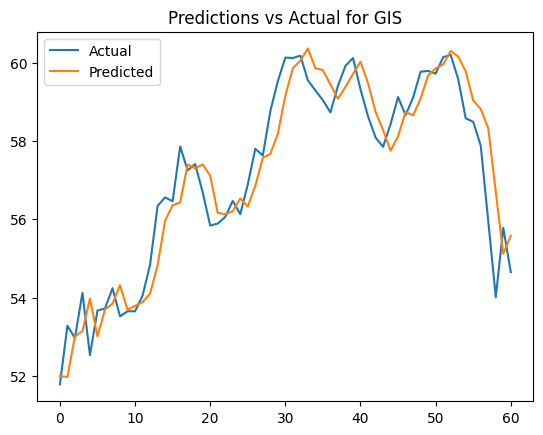

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
MAE for GLW: 0.22982635233160417
MSE for GLW: 0.0712427242848101
RMSE for GLW: 0.2669133272896093
R2 Score for GLW: 0.13836622484564354


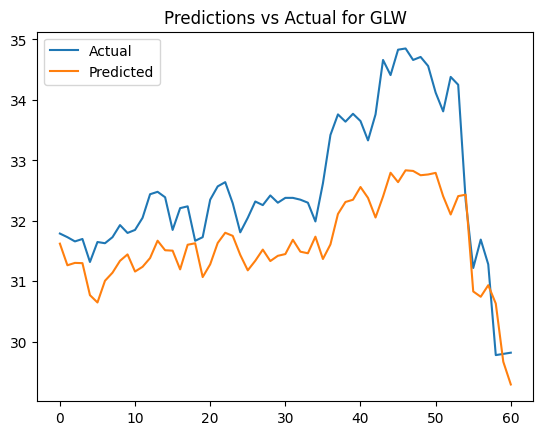

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
MAE for GPC: 0.22993781407406877
MSE for GPC: 0.09615811144513801
RMSE for GPC: 0.3100937139723055
R2 Score for GPC: 0.8680486956815763


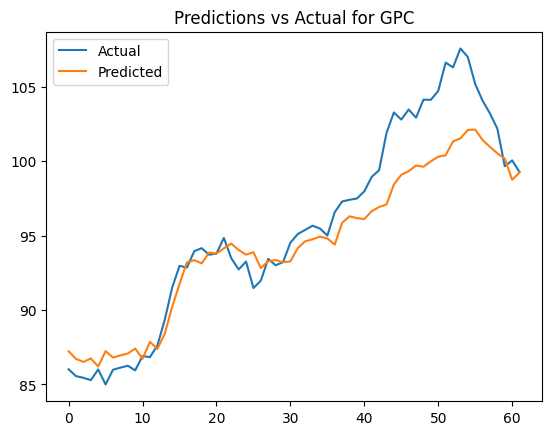

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
MAE for GPS: 0.09151971242360023
MSE for GPS: 0.014076131777773308
RMSE for GPS: 0.11864287495578194
R2 Score for GPS: 0.8570657776548373


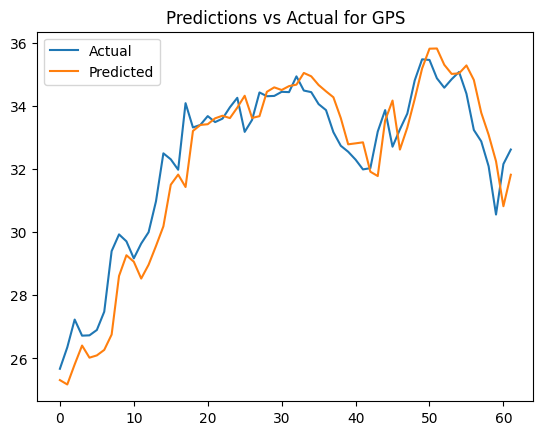

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
MAE for GRMN: 0.09663485800196447
MSE for GRMN: 0.015179087119760477
RMSE for GRMN: 0.12320343793807248
R2 Score for GRMN: 0.6784273119497278


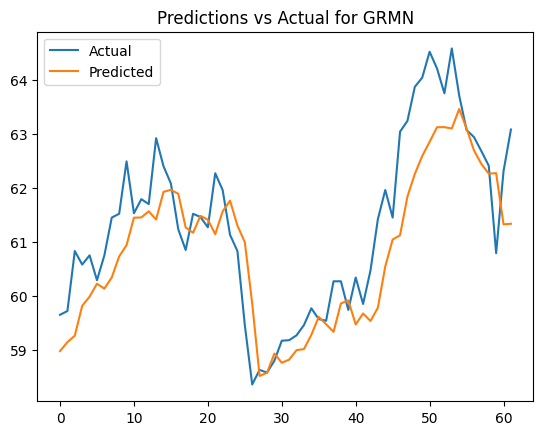

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
MAE for GS: 0.45390511824218194
MSE for GS: 0.23777767380383874
RMSE for GS: 0.48762452133156586
R2 Score for GS: -0.8828445550064346


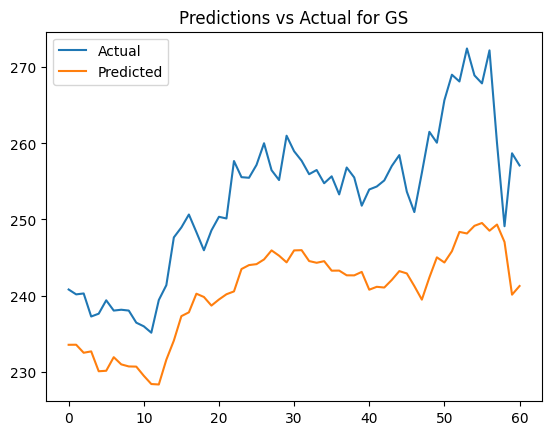

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
MAE for GT: 0.06745815859560603
MSE for GT: 0.007341990357507825
RMSE for GT: 0.0856854150804431
R2 Score for GT: 0.9223600470055241


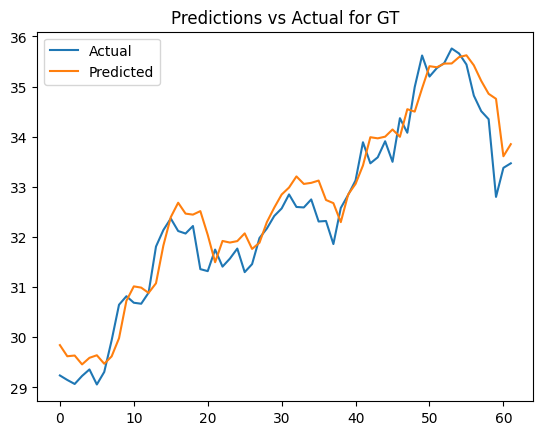

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
MAE for GWW: 0.19153522787529473
MSE for GWW: 0.13052496230386448
RMSE for GWW: 0.36128238582010125
R2 Score for GWW: 0.8606260978161702


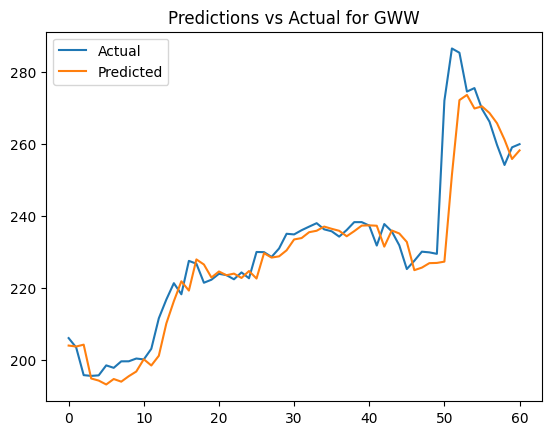

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
MAE for HAL: 0.08597611702361398
MSE for HAL: 0.01232561801570363
RMSE for HAL: 0.11102079992372434
R2 Score for HAL: 0.9557306343480768


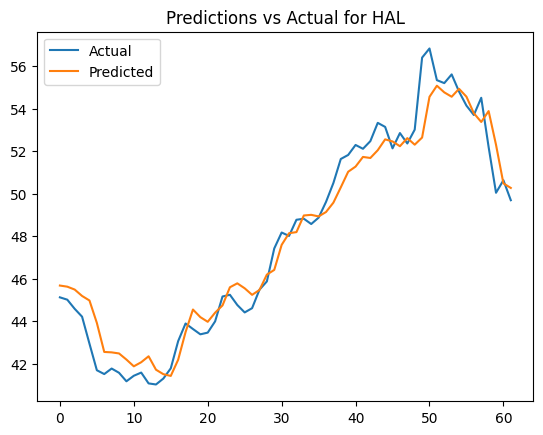

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
MAE for HAS: 0.07706367287485008
MSE for HAS: 0.012011646625096153
RMSE for HAS: 0.10959765793618106
R2 Score for HAS: 0.14809990902909587


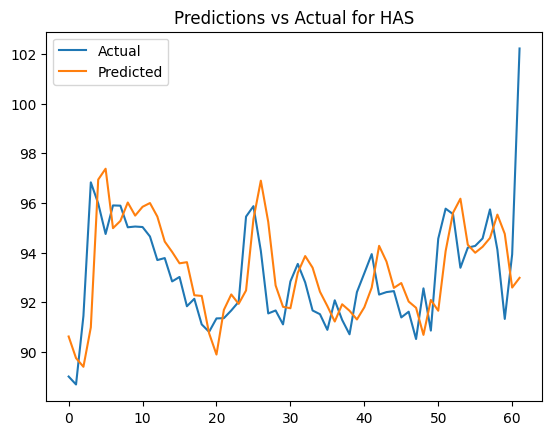

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
MAE for HBAN: 0.3533907632325091
MSE for HBAN: 0.174802388433921
RMSE for HBAN: 0.418093755554805
R2 Score for HBAN: 0.385792278091864


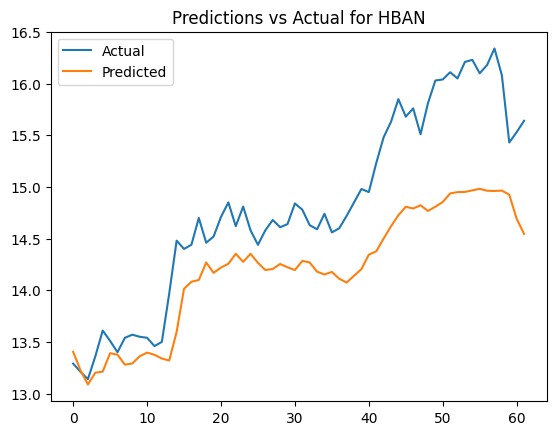

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
MAE for HBI: 0.04184021675675433
MSE for HBI: 0.0030261623819202526
RMSE for HBI: 0.05501056609343565
R2 Score for HBI: 0.8978554051115075


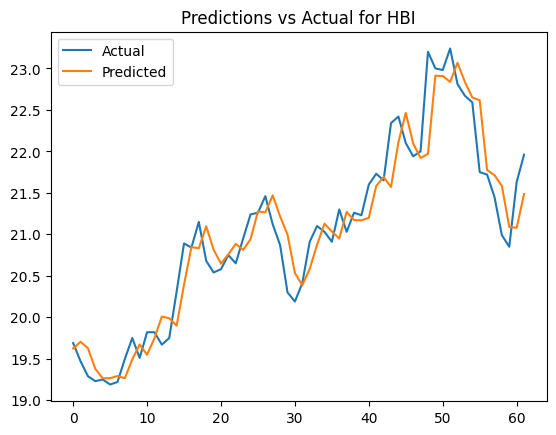

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
MAE for HCA: 0.12433677648660225
MSE for HCA: 0.03205451224231498
RMSE for HCA: 0.17903773971516446
R2 Score for HCA: 0.8301001224087939


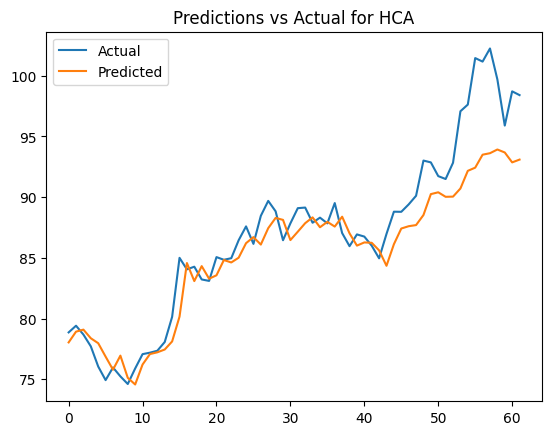

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
MAE for HCN: 0.11070279656076065
MSE for HCN: 0.022124344874064367
RMSE for HCN: 0.1487425456083913
R2 Score for HCN: 0.9372898191149729


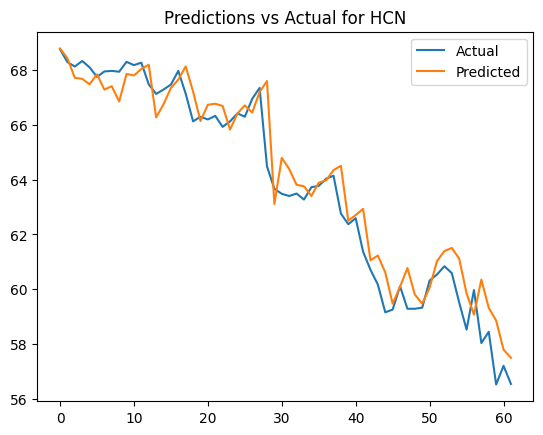

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
MAE for HES: 0.09351463873956475
MSE for HES: 0.01336563711990251
RMSE for HES: 0.11560984871498842
R2 Score for HES: 0.7744916689035112


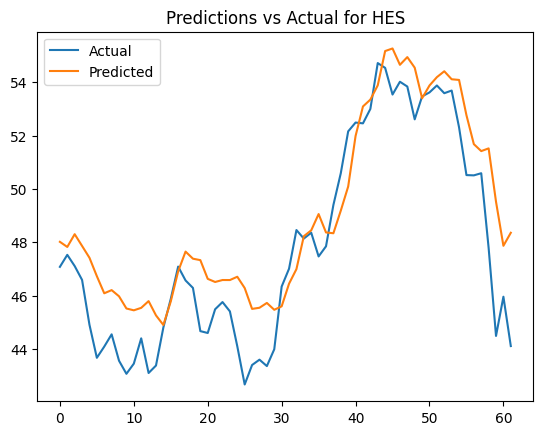

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictions_dict = {}
y_test_dict_inverse_scaled = {}
mae_dict = {}
mse_dict = {}
rmse_dict = {}
r2_dict = {}

for key in X_test_dict.keys():
    # Make predictions for the current key
    predictions = models_dict[key].predict(X_test_dict[key])
    # Inverse scale the predictions
    y_pred = inverse_scaling(predictions, means_dict[key]['close'], stds_dict[key]['close'])
    # Inverse scale y_test
    y_test_inverse_scaled = inverse_scaling(y_test_dict[key], means_dict[key]['close'], stds_dict[key]['close'])

    # Calculate MAE, MSE, RMSE, and R2 score for the current key
    mae = mean_absolute_error(y_test_dict[key], predictions)
    mse = mean_squared_error(y_test_dict[key], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_dict[key], predictions)

    # Print the metrics
    print(f"MAE for {key}: {mae}")
    print(f"MSE for {key}: {mse}")
    print(f"RMSE for {key}: {rmse}")
    print(f"R2 Score for {key}: {r2}")

    # Store metrics in dictionaries
    predictions_dict[key] = y_pred
    y_test_dict_inverse_scaled[key] = y_test_inverse_scaled
    mae_dict[key] = mae
    mse_dict[key] = mse
    rmse_dict[key] = rmse
    r2_dict[key] = r2

    # Plot the results for the current key
    plt.figure()
    plt.plot(y_test_inverse_scaled, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"Predictions vs Actual for {key}")
    plt.legend()
    plt.show()
